# Лабораторная работа №1
## Градиентный спуск
Трутнев Алексей Игоревич вариант №5

In [83]:
import time
from dataclasses import dataclass, field
from collections import defaultdict
from typing import Dict, List

import numpy as np
from numpy.typing import NDArray
from typing import Callable
from matplotlib import pyplot as plt
import pickle

import cvxpy as cp

In [84]:
results_dump_file = 'results_dump_file.pkl'

Задача оптимизации

$\min\{ (x-\mu_0)^\top A (x-\mu_0) : ||x||_2^2 \leq 1 \}$, где
* $x \in \mathbb{R}^n$, $A$ - симметричная, положительно определенная матрица
* $\mu_0 = (1,1,\dots,1)^\top \in \mathbb{R}^n$

In [85]:
def function(x: NDArray, A: NDArray, mu: NDArray) -> float:
    return (x - mu).T @ A @ (x - mu)


def limitation(x: NDArray) -> float:
    return np.sum(np.power(x, 2))

In [86]:
def check_symmetric(A: NDArray) -> bool:
    return (A==A.T).all()


def check_positive_definition(A: NDArray) -> bool:
    n = A.shape[0]
    test_x = np.random.random(n)
    return (test_x.T @ A @ test_x) > 0


def get_symmetric_matrix(n: int) -> NDArray:
    A = np.random.rand(n, n)
    matrix = A @ A.T
    assert check_symmetric(matrix) and check_positive_definition(matrix)
    return matrix

### Ограничение
$c(x) = ||x||_2^2 = \sum_{i=1}^{n} x_i^2 \leq 1$, где $x = (x_1, x_2, \dots, x_n)^\top \in \mathbb{R}^n$

Градиент имеет вид: $\nabla c(x) = (2x_1, 2x_2, \dots, 2x_n)^\top = 2x \in \mathbb{R}^n$


### Функция
$f(x) = (x-\mu_0)^\top A (x-\mu_0)$

Градиент имеет вид: $\nabla x^\top A x = (A+A^\top)x =$ [при симметричной матрице $A$] $= 2Ax$

In [87]:
def grad_function(x: NDArray, A: NDArray, mu: NDArray) -> NDArray:
    return 2 * A @ (x - mu)


def grad_limitation(x: NDArray) -> NDArray:
    return 2 * x

In [88]:
def check_optimality(x: NDArray, A: NDArray, mu: NDArray) -> bool:
    return grad_limitation(x) @ -grad_function(x, A, mu) >= 0

1. Исследование на выпуклость

Дана квадратичная функция $f(x)=(x-\mu_0)^\top A (x-\mu_0)$, где $A \in \mathbb{R}^{n^2}$ - симметричная, положительно определенная матрица. Ограничение $c(x)$ выпукло.
Когда матрица коэффициентов $A$ - положительно определена, функция $f(x)$ будет выпуклой.


Проверим этот факт через условие выпуклости:

$f(\lambda x + (1− \lambda)y) \leq \lambda f(x) + (1− \lambda)f(y)$, где $0 \geq \lambda \leq 1$


In [89]:
test_n = 100
test_A = get_symmetric_matrix(test_n)

test_mu = np.ones(test_n)
test_x = np.random.random(test_n)
test_y = np.random.random(test_n)


def test(test_x: NDArray, test_y: NDArray, test_A: NDArray, test_mu: NDArray, test_lambda: float) -> bool:
    return function(test_lambda*test_x + (1-test_lambda)*test_y, test_A, test_mu) \
            <= test_lambda * function(test_x, test_A, test_mu) + (1-test_lambda) * function(test_y, test_A, test_mu)

results = [
    test(test_x, test_y, test_A, test_mu, test_lambda) for test_lambda in np.linspace(0, 1, 10)
]

all(results)

True

2. Для каждого значения $n \in \{10, 20,\dots, 100\}$ сгенерируйте $N = 100$ тестовых примеров. В каждом случае найдите глобальный минимум, $x^* \in \mathbb{R}^n$, с помощью CVX. Проверьте, что в точке минимума выполняется условие оптимальности (т.е. вектора градиента к ограничению и антиградиента к целевой функции сонаправлены).


### Описание тестовых данных

Для проведения экспериментов согдана система хранения данных для экспериментов:

* Размерность задачи $\{10, 20, \dots, 100\}$
    * Для каждого из них свой набор из 100 тестовых згначений матрицы $A$
        * Для каждого из значения $A$ свой набор стартовых точек $x_{0}$

In [90]:
@dataclass
class TestCase:
    A: NDArray
    default_x: list[NDArray] = field(default_factory=list)
    solver_x: NDArray = None
    my_x: list[NDArray] = field(default_factory=list)
    num_iterations: list[int] = field(default_factory=list)
    time: list[int] = field(default_factory=list)
    accuracy: list[float] = field(default_factory=list)


def generate_data(min_dim: int, max_dim: int, step_dim: int, num_test_cases: int, num_experiments: int) -> Dict[int, List[TestCase]]:
    dimensionality_range = range(min_dim, max_dim+1, step_dim)

    data = defaultdict(list)
    for n in dimensionality_range:
        for _ in range(num_test_cases):
            A = get_symmetric_matrix(n)
            test_case = TestCase(A)
            for _ in range(num_experiments):
                x = np.random.random(n)
                test_case.default_x.append(x)
            data[n].append(test_case)
    return data

In [94]:
test_data = generate_data(
    min_dim=10,
    max_dim=100,
    step_dim=10,
    num_test_cases=100,
    num_experiments=100
    )

In [95]:
float_calculation_tol = 1e-4

for n, test_cases in test_data.items():
    mu = np.ones(n)

    for test_case in test_cases:
        x_started = test_case.default_x[0]

        x = cp.Variable(n)
        optimization_func = cp.quad_form(x=(x - mu), P=test_case.A)
        objective = cp.Minimize(optimization_func)

        constraints = [
            cp.sum_squares(x) <= 1
        ]

        problem = cp.Problem(objective, constraints)
        problem.solve(solver=cp.SCS)

        test_case.solver_x = x.value

        if not check_optimality(x.value, test_case.A, mu):
            print(f'Optimality condition is not satisfied.')

        if limitation(x.value) - 1 > float_calculation_tol:
            print('Constraint error')

В данном эксперименте мы воспользовались библиотекой *cvxpy* и солвером *SCS* для решения выпуклой задачи оптимизации с ограничениями.

3. Для каждого значения $n \in \{10, 20,\dots, 100\}$ и для каждого тестового примера сгенерируйте 100 начальных точек. В зависимости от варианта реализуйте следующие методы решения задачи (1) для заданной точности $\epsilon = 0.01$.

### Градиентный спуск c *Exact Line Search*

Градиентный спуск с Exact Line Search — это метод оптимизации, используемый для нахождения минимума функции. Он основан на итеративном движении в направлении, противоположном градиенту функции в текущей точке, что соответствует направлению наискорейшего убывания функции.


#### Принцип работы:

1. **Вычисление градиента**: На каждом шаге вычисляется градиент функции потерь в текущей точке $x$. Градиент $\nabla f(x)$ указывает направление наискорейшего роста функции.

2. **Exact Line Search**: Затем выполняется поиск вдоль линии. Это означает, что в направлении, противоположном градиенту, ищется такой размер шага $s$, который минимизирует функцию потерь $f(x - s \Delta x)$.

3. **Обновление точки**: После того как найден оптимальный размер шага, текущая точка $x$ обновляется, чтобы приблизиться к минимуму функции.


#### Формально может быть записан в виде:

Повторять, пока не достигнуто условие остановки $||\nabla f(x)||_{2} \leq \epsilon$, где $\epsilon > 0$:
1. Определить градиент функции в точке $\Delta x = \nabla f(x)$.
2. *Exact Line Search*. Определить шаг алгоритма $s \geq 0$:
    1. Найти такой шаг градиента $s$ (*learning rate*), который приводит к наиболее оптимальному решению: $\argmin_{s \geq 0}f(x - s \Delta x)$
3. Обновление точки. $x = x - s\Delta x$.


#### Преимущества:

- Exact Line Search позволяет точно определить размер шага на каждой итерации, что может ускорить сходимость к минимуму.
- Отсутствие фиксированного параметра learning rate, фактически он подбирается автоматически для каждого шага оптимизации.
- Простота имплементации.

#### Недостатки:

- Нахождение оптимального размера шага на каждом шаге может быть вычислительно затратным.
- Метод может застрять в локальных минимумах, а не находить глобальный минимум.
- Результат оптимизации может зависеть от выбора начальной точки.


In [79]:
def print_verbose(string: str, verbose: bool) -> None:
    if verbose:
        print(string, flush=True)


def print_iteration(iteration: int, y: int, x: NDArray, verbose: bool) -> None:
    print_verbose(f'Iteration {iteration}, y: {y}, x: {x}', verbose)


def get_exact_line_alpha(func: Callable,
                         x: NDArray, A: NDArray, mu: NDArray, delta_x: NDArray,
                         min_s: float = 0, max_s: float = 1., step_s: float = 0.001) -> float:
    s_values = np.arange(min_s+step_s, max_s, step_s)
    func_results = [func(x-s*delta_x, A, mu) for s in s_values]
    return s_values[np.argmin(func_results)]


@dataclass
class GradDescentResult:
    x: NDArray
    y: float
    time: float
    iterations: int
    accuracy: float


def grad_desc_exact_line(*,
                    x: NDArray,
                    A: NDArray,
                    func: Callable,
                    grad_func: Callable,
                    epsilon: float = 1.e-2,
                    max_iters: int = 1e5,
                    min_s: float = 0.,
                    max_s: float = 0.5,
                    step_s: float = 1e-5,
                    verbose: bool = False) -> GradDescentResult:
    """
    gradient descent with exact line minimization
    """
    start_time = time.time()

    mu = np.ones_like(x)

    print_iteration(0, func(x, A, mu), x, verbose=verbose)

    for iteration in range(1, int(max_iters)+1):

        delta_x = grad_func(x, A, mu)

        if np.linalg.norm(delta_x) < epsilon:
            print_verbose('STOP Condition', verbose=verbose)
            break

        exact_alpha = get_exact_line_alpha(func, x, A, mu, delta_x, min_s, max_s, step_s)
        print_verbose(f'Selected alpha is {exact_alpha}', verbose=verbose)

        x -= exact_alpha * delta_x
    else:
        print_verbose('STOP Condition', verbose=verbose)

    end_time = time.time()

    result = GradDescentResult(x=x,
                               y=func(x, A, mu),
                               time=end_time-start_time,
                               iterations=iteration,
                               accuracy=np.linalg.norm(grad_func(x, A, mu)))
    print_verbose(f'Optimal y: {result.y}, obtained in {result.x}', verbose=verbose)
    return result

In [99]:
for n, test_cases in test_data.items():
    mu = np.ones(n)

    for test_case_id, test_case in enumerate(test_cases):

        for x_started in test_case.default_x:

            result = grad_desc_exact_line(x=x_started, A=test_case.A, func=function, grad_func=grad_function, verbose=False)

            test_case.my_x.append(result.x)
            test_case.time.append(result.time)
            test_case.num_iterations.append(result.iterations)
            test_case.accuracy.append(result.accuracy)

    print(f'[n={n}]: Avg time {np.mean(test_case.time):.6f} Avg iter {np.mean(test_case.num_iterations):.2f} Avg accuracy {np.mean(test_case.accuracy):.2f}', flush=True)

with open(results_dump_file, 'wb') as handle:
    pickle.dump(test_data, handle)

[n=10]: Avg time 1.699621 Avg iter 81.00 Avg accuracy 0.01
[n=20]: Avg time 5.041990 Avg iter 226.00 Avg accuracy 0.01
[n=30]: Avg time 13.225054 Avg iter 2991.00 Avg accuracy 0.01
[n=40]: Avg time 16.305452 Avg iter 3648.50 Avg accuracy 0.01
[n=50]: Avg time 19.149586 Avg iter 4075.00 Avg accuracy 0.01
[n=60]: Avg time 49.831344 Avg iter 5873.50 Avg accuracy 0.02
[n=70]: Avg time 89.318018 Avg iter 5503.00 Avg accuracy 0.01
[n=80]: Avg time 100.137591 Avg iter 3507.00 Avg accuracy 0.01
[n=90]: Avg time 385.716565 Avg iter 100000.00 Avg accuracy 19018.81



> Среднее время искажено, так как для экспериментов использовалось HW без активного охлаждения (Apple Silicon M1), на больших размерностях было заметено сильное снижение вычислительной мощности.

In [13]:
with open(results_dump_file, 'rb') as handle:
    test_data = pickle.load(handle)

[Done] Объясните принцип работы метода, опишите его преимущества и недостатки.

[Done] Для каждого значения $n \in \{10,20,\dots,100\}$ подсчитайте среднее время работы метода и среднее число итераций (усреднение проводится по всем начальным точкам и по всем тестовым примерам)

[Done] Для одного тестового примера при $n = 10$ и нескольких различных начальных точек постройте зависимость точности от числа итераций. [Done] Зависит ли скорость сходимости метода от отношения максимального и минимального собственных чисел матрицы $A$?

Text(0, 0.5, 'Точность в виде $||\\nabla f(x)||_{2} $')

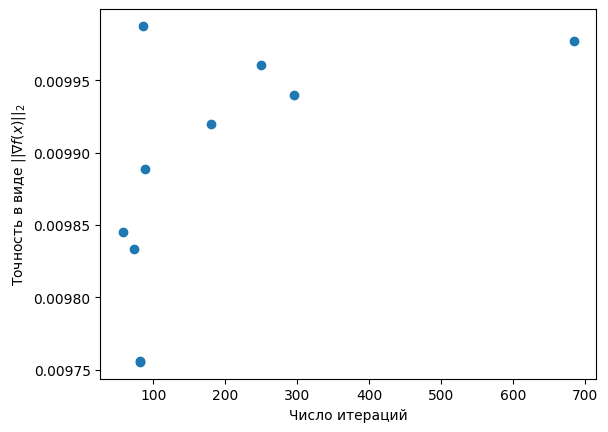

In [14]:
'''
Для одного тестового примера при $n = 10$ и нескольких различных начальных
точек постройте зависимость точности от числа итераций.
'''

test_case = test_data[10][0]

axes = plt.gca()
axes.scatter(test_case.num_iterations, test_case.accuracy)
axes.set_xlabel('Число итераций')
axes.set_ylabel('Точность в виде $||\\nabla f(x)||_{2} $')

На тестовом наборе данных сильная зависимость точности от числа итераций не была выявлена. Это связано с тем, что какая бы начальная точка не была выбрана, критерий остановки - заданная точность 0.01. Для проверки гипотезы связи точности с количеством итераций, необходимо провести дополнительтный эксперимент, где критерий остановки алгоритма - $n$ итераций оптимизации.

Text(0, 0.5, 'Число итераций (Скорость сходимости)')

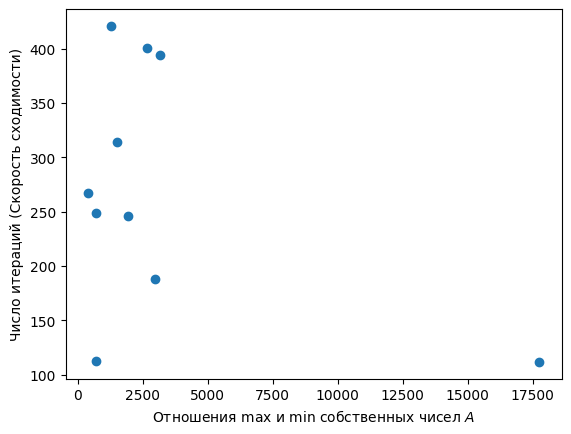

In [15]:
'''Зависит ли скорость сходимости метода от отношения максимального
и минимального собственных чисел матрицы $A$?
'''

data_x = []
data_y = []

for test_case in test_data[10]:
    eigenvalues = np.linalg.eigvals(test_case.A)
    ratio = max(eigenvalues)/ min(eigenvalues)

    data_x.append(ratio)
    data_y.append(np.mean(test_case.num_iterations))

axes = plt.gca()
axes.scatter(data_x, data_y)

axes.set_xlabel('Отношения max и min собственных чисел $A$')
axes.set_ylabel('Число итераций (Скорость сходимости)')

В данном эксперименте мы моджем наблюдать отсутствие связи между числом итераций и максимальным отношением собственных чисел матрицы $A$. Однако на графике замметен выброс, причем при различных запусках, как минимум один выброс удается обнаружить. Возможно это связано с особенностями генерации матрицы $A$.